In [53]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.inspection import permutation_importance
from torch.utils.data import Dataset, DataLoader
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')

In [2]:
# Load in original datasets
df_train_orig = pd.read_csv('data/train.csv')
df_test_orig = pd.read_csv('data/test.csv')

display(df_train_orig)
#display(df_test_orig)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [17]:
# Describe Data

print(f'\n* Number of labels: {df_train_orig.shape[1]}, which are:')

#for col in df_train_orig.columns:
#    print(
#        f'{col:15s} with examples: {df_train_orig[col][0]}, {df_train_orig[col][1]}, {df_train_orig[col][2]}')

#print('\n* The "describe" of the data is:')

display(df_train_orig.describe())

print(f'\n* The number of entires is {df_train_orig.shape[0]}')

print(f'\n* The volumns with nans are:')
for col in df_train_orig.columns:
     num_nams = df_train_orig[col].isna().sum()
     if num_nams > 0:
        print (f'{col:^15s} has {num_nams:>5d}  nans or {100*num_nams/len(df_train_orig):>6.2f}%.')
#display(df_test_orig.isna().sum())


* Number of labels: 81, which are:


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000



* The number of entires is 1460

* The volumns with nans are:
  LotFrontage   has   259  nans or  17.74%.
     Alley      has  1369  nans or  93.77%.
  MasVnrType    has     8  nans or   0.55%.
  MasVnrArea    has     8  nans or   0.55%.
   BsmtQual     has    37  nans or   2.53%.
   BsmtCond     has    37  nans or   2.53%.
 BsmtExposure   has    38  nans or   2.60%.
 BsmtFinType1   has    37  nans or   2.53%.
 BsmtFinType2   has    38  nans or   2.60%.
  Electrical    has     1  nans or   0.07%.
  FireplaceQu   has   690  nans or  47.26%.
  GarageType    has    81  nans or   5.55%.
  GarageYrBlt   has    81  nans or   5.55%.
 GarageFinish   has    81  nans or   5.55%.
  GarageQual    has    81  nans or   5.55%.
  GarageCond    has    81  nans or   5.55%.
    PoolQC      has  1453  nans or  99.52%.
     Fence      has  1179  nans or  80.75%.
  MiscFeature   has  1406  nans or  96.30%.


In [18]:
# Lot Area
def normalize_data(data, do_log=True):
    data = torch.tensor(data)   
    data = torch.nan_to_num(data,nan=data.nanmedian())
    if do_log:
        data = data.log()
    
    data = data - data.mean()
    data = data/data.std()
    return data

def get_corrcoef(x,y):
    # Correlation Cooeficient
    c = torch.concatenate((x.view(1,-1),y.view(1,-1)),dim=0)
    c = torch.corrcoef(c)
    return c[0,1]

def examine_data(data, x_label,y_label):

    #print (f'\nExamining {x_label} effect on {y_label}')
    #print (f'Number of nans in {x_label} is {data[x_label].isna().sum()}')

    x = normalize_data(data[x_label])
    y = normalize_data(data[y_label])

    c = get_corrcoef(x,y)

    plt.scatter(x,y,label=f'Correlation = {c:.3f}')
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label);

In [25]:
y_label = 'SalePrice'

corrs = []
names = []
for x_label in df_test_orig.columns:

    try:
        x = normalize_data(df_train_orig[x_label])
    except:
        continue
    y = normalize_data(df_train_orig[y_label])
    c = torch.nan_to_num(get_corrcoef(x,y),nan=0.0)
    if abs(c) > 0.1:
        corrs.append(c)
        names.append(x_label)


for x, y in [(x,y) for y, x in sorted(zip(corrs, names))][::-1]:
    #print (x,y.item())
    print (f'Correlation of {x:^13s} with {y_label} is: {y:6.3f}')
    #plt.figure()
    #examine_data(df_train_orig, x_label = x, y_label=y_label)

Correlation of  OverallQual  with SalePrice is:  0.794
Correlation of   GrLivArea   with SalePrice is:  0.730
Correlation of   1stFlrSF    with SalePrice is:  0.609
Correlation of   YearBuilt   with SalePrice is:  0.584
Correlation of YearRemodAdd  with SalePrice is:  0.566
Correlation of TotRmsAbvGrd  with SalePrice is:  0.539
Correlation of  GarageYrBlt  with SalePrice is:  0.494
Correlation of    LotArea    with SalePrice is:  0.400
Correlation of  LotFrontage  with SalePrice is:  0.346


In [57]:
class HousingData(Dataset):
    def __init__(self, my_df, y_label) -> None:
        super().__init__()

        for col in my_df:
            my_df[col] = normalize_data(my_df[col])

        y_df = my_df[y_label]
        x_df = my_df.drop(columns=[y_label])

        self.x = torch.tensor(x_df.values, dtype=torch.float32)
        self.y = torch.tensor(y_df.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
# X and Y data
y_label = 'SalePrice'
my_df = df_train_orig.copy()
my_df = my_df[names + [y_label]]

my_data = HousingData(my_df, y_label)
my_dl = DataLoader(my_data, batch_size=64)

In [69]:
for batch in my_dl:
    x, y = batch
    print (x.shape, y.shape)
    break

torch.Size([64, 9]) torch.Size([64])


In [116]:
# Define model
class HousingNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(9, 9),
            nn.ReLU(),
            nn.Linear(9, 9),
            nn.ReLU(),
            nn.Linear(9, 9),
            nn.ReLU(),
            nn.Linear(9, 1)
        )

    def forward(self, x):
        logits = self.model(x)
        return logits

model = HousingNetwork()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


In [117]:

epochs = 2000

for t in range(1,epochs+1):
    size = len(my_dl.dataset)
    model.train()
    losses = []
    for batch, (x, y) in enumerate(my_dl):
        x, y = x, y

        # Compute prediction error
        logits = model(x).flatten()
        loss = loss_fn(logits, y)
        

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss)
    
    if t % 100 == 0:
        print (f'Epoch t has loss = {torch.tensor(losses).mean().item():.3f}')



            

Epoch t has loss = 0.317
Epoch t has loss = 0.194
Epoch t has loss = 0.175
Epoch t has loss = 0.165
Epoch t has loss = 0.158
Epoch t has loss = 0.154
Epoch t has loss = 0.151
Epoch t has loss = 0.150
Epoch t has loss = 0.149
Epoch t has loss = 0.148
Epoch t has loss = 0.147
Epoch t has loss = 0.146
Epoch t has loss = 0.145
Epoch t has loss = 0.145
Epoch t has loss = 0.144
Epoch t has loss = 0.144
Epoch t has loss = 0.143
Epoch t has loss = 0.143
Epoch t has loss = 0.142
Epoch t has loss = 0.142


In [115]:
print (model)
print (sum(p.numel() for p in model.parameters()))

HousingNetwork(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=9, bias=True)
    (1): ReLU()
    (2): Linear(in_features=9, out_features=9, bias=True)
    (3): ReLU()
    (4): Linear(in_features=9, out_features=9, bias=True)
    (5): ReLU()
    (6): Linear(in_features=9, out_features=1, bias=True)
  )
)
280


<AxesSubplot: xlabel='LotArea', ylabel='Count'>

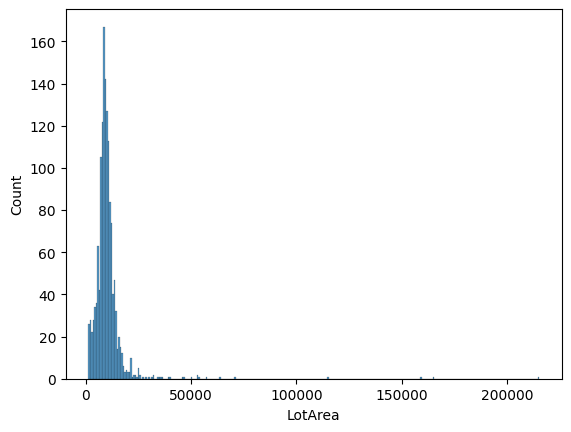

In [158]:
sns.histplot(data=df_train_orig['LotArea'])

In [159]:
# Lot Area
def normalize_data(data, do_log=True):
    data = torch.tensor(data)   
    data = torch.nan_to_num(data,nan=data.nanmedian())
    if do_log:
        data = data.log()
    
    data = data - data.mean()
    data = data/data.std()
    return data

def get_corrcoef(x,y):
    # Correlation Cooeficient
    c = torch.concatenate((x.view(1,-1),y.view(1,-1)),dim=0)
    c = torch.corrcoef(c)
    return c[0,1]

def examine_data(data, x_label,y_label):

    #print (f'\nExamining {x_label} effect on {y_label}')
    #print (f'Number of nans in {x_label} is {data[x_label].isna().sum()}')

    x = normalize_data(data[x_label])
    y = normalize_data(data[y_label])

    c = get_corrcoef(x,y)

    plt.scatter(x,y,label=f'Correlation = {c:.3f}')
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label);




Examining LotArea effect on SalePrice
Number of nans in LotArea is 0


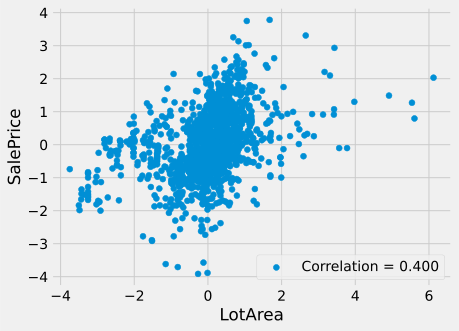

In [89]:
# Lot Area
examine_data(df_train_orig, x_label = 'LotArea', y_label='SalePrice')


Examining MSSubClass effect on SalePrice
Number of nans in MSSubClass is 0


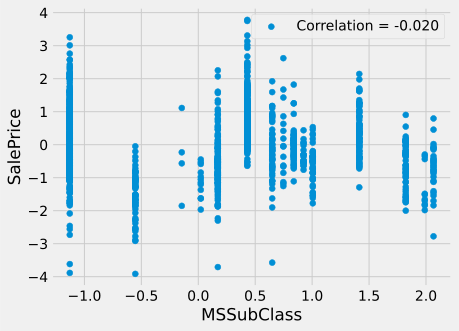

In [84]:
# Lot Area
examine_data(df_train_orig, x_label = 'MSSubClass', y_label='SalePrice')


Examining LotFrontage effect on SalePrice
Number of nans in LotFrontage is 259


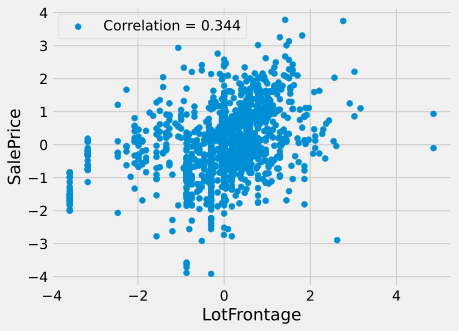

In [85]:
examine_data(df_train_orig, x_label = 'LotFrontage', y_label='SalePrice')


Examining OverallQual effect on SalePrice
Number of nans in OverallQual is 0


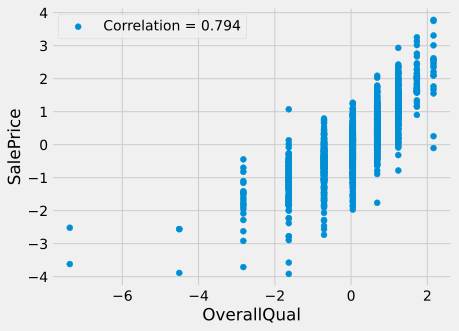

In [78]:
examine_data(df_train_orig, x_label = 'OverallQual', y_label='SalePrice')


Examining OverallCond effect on SalePrice
Number of nans in OverallCond is 0


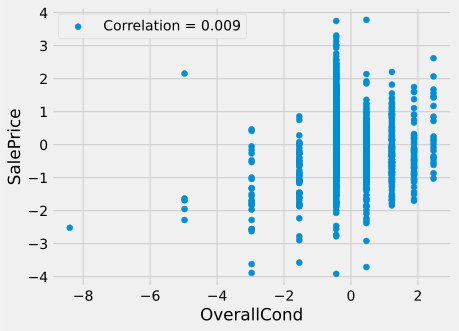

In [86]:
examine_data(df_train_orig, x_label = 'OverallCond', y_label='SalePrice')


Examining YearBuilt effect on SalePrice
Number of nans in YearBuilt is 0


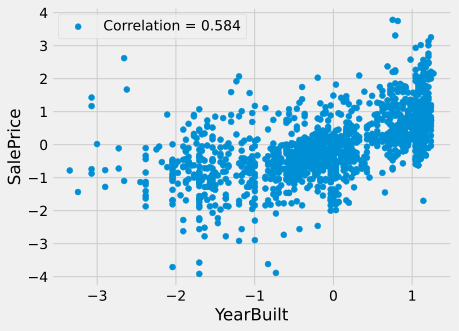

In [80]:

examine_data(df_train_orig, x_label = 'YearBuilt', y_label='SalePrice')

In [164]:
y_label = 'SalePrice'

corrs = []
names = []
for x_label in df_test_orig.columns:

    try:
        x = normalize_data(df_train_orig[x_label])
    except:
        continue
    y = normalize_data(df_train_orig[y_label])
    c = torch.nan_to_num(get_corrcoef(x,y),nan=0.0)
    if abs(c) > 0.05:
        corrs.append(c)
        names.append(x_label)


for x, y in [(x,y) for y, x in sorted(zip(corrs, names))][::-1]:
    #print (x,y.item())
    print (f'Correlation of {x:^13s} with {y_label} is: {y:6.3f}')
    plt.figure()
    #examine_data(df_train_orig, x_label = x, y_label=y_label)

    

Correlation of  OverallQual  with SalePrice is:  0.794
Correlation of   GrLivArea   with SalePrice is:  0.730
Correlation of   1stFlrSF    with SalePrice is:  0.609
Correlation of   YearBuilt   with SalePrice is:  0.584
Correlation of YearRemodAdd  with SalePrice is:  0.566
Correlation of TotRmsAbvGrd  with SalePrice is:  0.539
Correlation of  GarageYrBlt  with SalePrice is:  0.494
Correlation of    LotArea    with SalePrice is:  0.400
Correlation of  LotFrontage  with SalePrice is:  0.346
Correlation of    MoSold     with SalePrice is:  0.051


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [165]:
class MyData()

['LotFrontage',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 '1stFlrSF',
 'GrLivArea',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'MoSold']

In [ ]:
names

In [34]:
def df_norm(data_df, xl):

    # Normalize data for label
    x = torch.tensor(data_df[xl])   
    x = torch.nan_to_num(x,nan=x.nanmedian())
    x = x.log2()
    x = x - x.min()
    #x = x - x.mean()
    #x = x/x.std()
    data_df[xl] = x
    return data_df

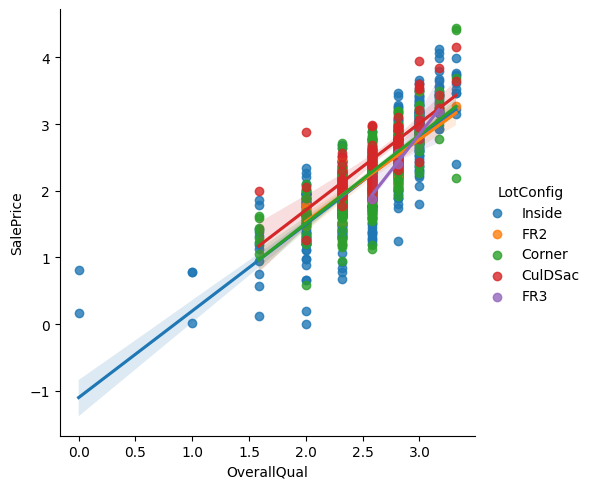

In [35]:
xl = "OverallQual"
yl = "SalePrice"
zl = "LotConfig"

my_df = df_train_orig.copy()
my_df = df_norm(my_df, xl)
my_df = df_norm(my_df, yl)

sns.lmplot(data=my_df ,x=xl,y=yl, hue=zl);

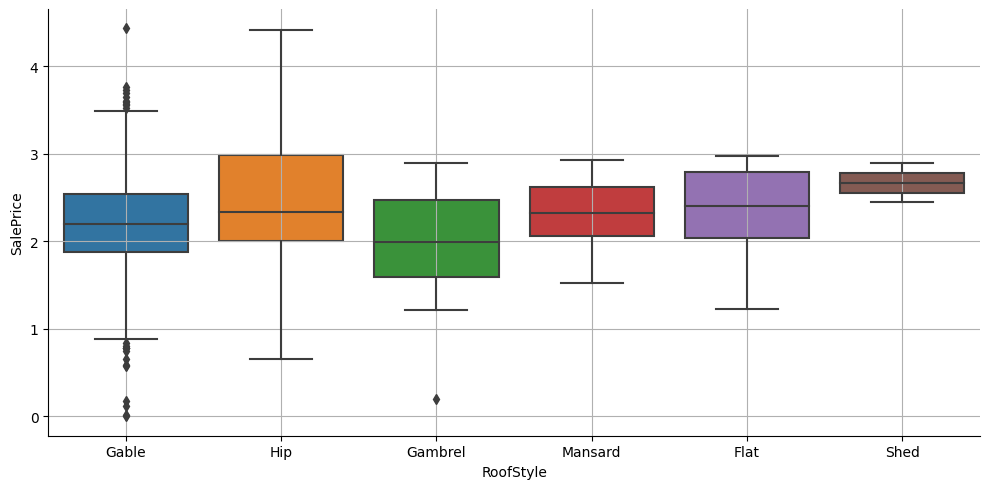

In [48]:
my_df = df_train_orig.copy()
my_df = df_norm(my_df, yl)

sns.catplot(
    data=my_df, x="RoofStyle", y="SalePrice",
    kind="box", aspect=2.0);
plt.grid()

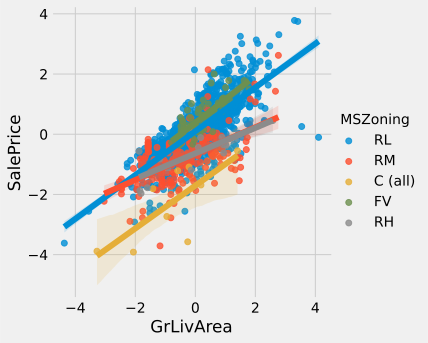

In [223]:
xl = "GrLivArea"
yl = "SalePrice"
zl = "MSZoning"

my_df = df_train_orig.copy()
my_df = df_norm(my_df, xl)
my_df = df_norm(my_df, yl)

sns.lmplot(data=my_df ,x=xl,y=yl, hue=zl);

In [181]:
x = np.array(df_train_orig[xl]).reshape(-1,1)
y = np.array(df_train_orig[yl]).reshape(-1,1)
z = np.array(df_train_orig[zl]).reshape(-1,1)
data = np.concatenate((x,y,z),axis=1)

my_df = pd.DataFrame(data, columns=[xl, yl, zl])
my_df


,GrLivArea,SalePrice,KitchenQual
0,1710,208500,Gd
1,1262,181500,TA
2,1786,223500,Gd
3,1717,140000,Gd
4,2198,250000,Gd
...,...,...,...
1455,1647,175000,TA
1456,2073,210000,TA
1457,2340,266500,Gd
1458,1078,142125,Gd


In [161]:
my_df

,GrLivArea,GrLivArea
0,1710,1710
1,1262,1262
2,1786,1786
3,1717,1717
4,2198,2198
...,...,...
1455,1647,1647
1456,2073,2073
1457,2340,2340
1458,1078,1078


In [99]:
e = torch.nn.Embedding(4,2)

In [153]:
# x = torch.arange(4)
x = torch.tensor(
    [[2.2, 1.0, -1.5, 0], [2.2, 1.0, -1.5, 0], [2.2, 1.0, -1.5, 0]])

# print (x.shape)

W = torch.randn((4, 2))

# print (x.shape)

E = e(torch.tensor([0, 1, 2, 3]))

# print (E)

# print (E.shape)

# print (e(torch.arange(4)) @ x)

# (x @ E).shape

M = torch.zeros((3, 4, 2))
for j in range(len(x)):
    for i in range(4):
        M[j] = E[i]*x[j, i]


In [154]:
M[1]

tensor([[-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.]], grad_fn=<SelectBackward0>)